# 42184 Data Science for Mobility
# 42577 Introduction to Business Analytics course
#                                   Challenge statement

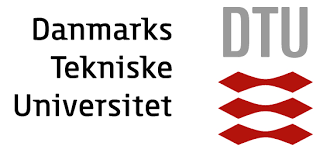

### * **Georgios Panagiotopoulos s223306**
### * **Tadeo Ramirez s221877**
### * **Cristobal Donoso s222508**

## Introduction

    The term sustainable mobility goes far beyond reducing emissions. The transport sector has the potential to improve the lives and livelihoods of billions of people. However, as well as meeting people’s needs today, the sector must be ready to respond to future generations’ expectations: this is the essence of sustainable development. Following this year’s topic, we have choosen to predict the total demand for the bike sharing system “BlueBikes” based in Boston, for 2 hours in the future. 

    As context BlueBikes is a company created in July 2011 and located in Metro Boston. Since it creations it have grown exponentially, from 3203 annual members to over 20000 members as of today:

![intro.jpeg](Data/intro.jpeg)

    First of all, we would like to mention that we have splitted data analysis into different parts based on our dataset at each different part of the project and also during the project we measure also how trips aggregation in different time intervals of **15,30,60,120** minutes impact our prediction.As far as the prediction part is concerned, we have trained our benchmark model  only with lags as features, which we have extended later with weather data of Boston. All in all, as the icing on the cake, we attempted to devide our station in different clusters, trying to predict the pickups per cluster.

## Prediction Challenge

In [14]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import main as main
import numpy as np
#import holidays
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline

In [5]:
# our initial data with the target variable
data = pd.read_csv('BikeSharing_Bluebikes2022.csv', index_col=0)

/home/georgep/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,597,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,178,MIT Pacific St at Purrington St,42.359573,-71.101295,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923,Subscriber,02139
1,411,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,3112,Subscriber,02139
2,476,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,6901,Customer,02124
3,466,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,5214,Customer,02124
4,752,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,19,Park Dr at Buswell St,42.347241,-71.105301,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214,Subscriber,02215


In [7]:
data.shape

(2305735, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2305735 entries, 0 to 487200
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         int64  
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           int64  
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  postal code              object 
dtypes: float64(4), int64(4), object(6)
memory usage: 263.9+ MB


In [9]:
#transforming the dates from object to datetime
for date_column in ['starttime','stoptime']:
    data[date_column] = pd.to_datetime(data[date_column], format='%Y-%m-%d %H:%M:%S')

In [19]:
'''
Through these functions we create our dataset for the prediction. We group by our intervals and calculate the pickups 
during them. We also add the lags based on this interval for the previous 2 hours. And we keep also the month
and the hours plus the minutes. We consider it as our benchmark model.
'''
df15 = main.DatetimeInterval(data, freq='15Min')
df30 = main.DatetimeInterval(data, freq='30Min')
df60 = main.DatetimeInterval(data, freq='60Min')
df120 = main.DatetimeInterval(data, freq='120Min')
picks15 = main.Lagging(df15, 15)
picks30 = main.Lagging(df30, 30)
picks60 = main.Lagging(df60, 60)
picks120 = main.Lagging(df120, 120)

In [20]:
picks15.head()

,pickups,month,hour,minute,"lag(pickups,60-75)","lag(pickups,75-90)","lag(pickups,90-105)","lag(pickups,105-120)"
starttime,,,,,,,,
2022-01-01 02:00:00,27.0,1,2,0,30.0,29.0,36.0,30.0
2022-01-01 02:15:00,14.0,1,2,15,21.0,30.0,29.0,36.0
2022-01-01 02:30:00,16.0,1,2,30,22.0,21.0,30.0,29.0
2022-01-01 02:45:00,16.0,1,2,45,24.0,22.0,21.0,30.0
2022-01-01 03:00:00,30.0,1,3,0,25.0,24.0,22.0,21.0


    Plotting the distribution of rides through the months we can infer the seasonality of the data, no matter the time intervals of course.

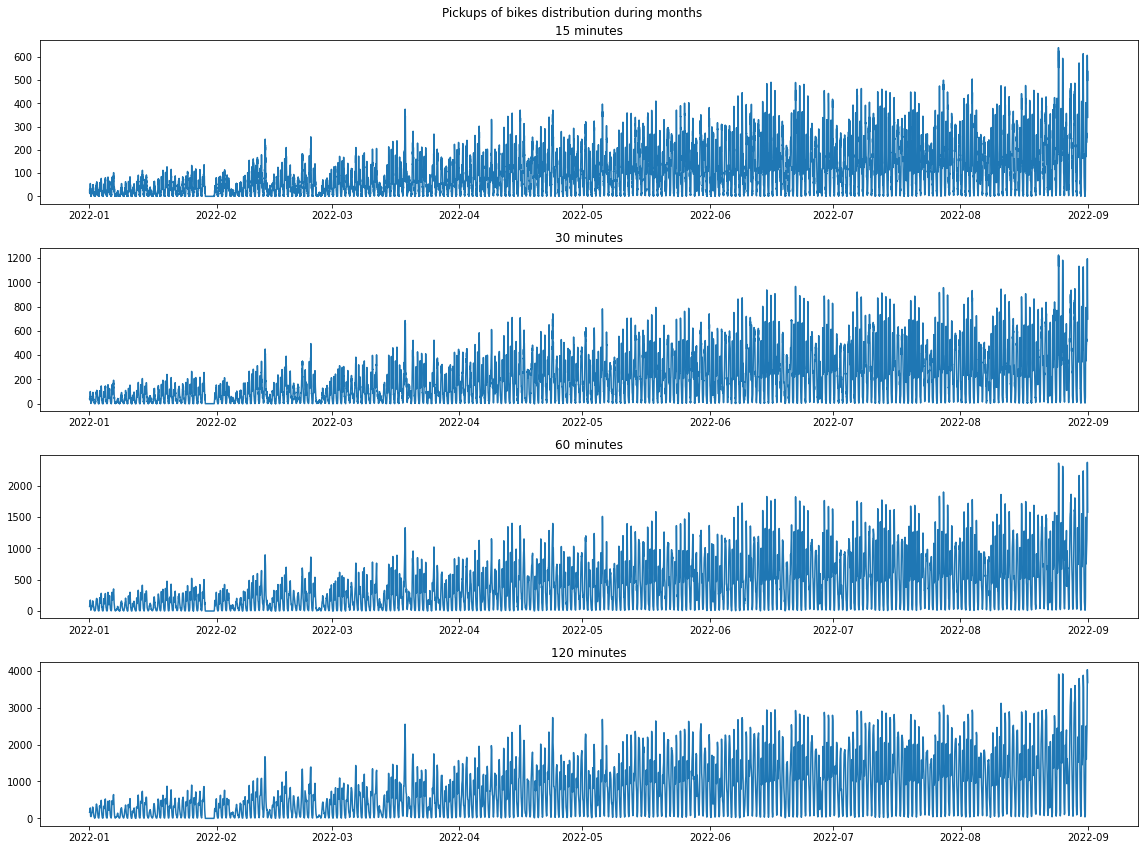

In [21]:
fig, axs = plt.subplots(len([picks15,picks30,picks60,picks120]), figsize=(16,12))
fig.suptitle('Pickups of bikes distribution during months')

for i, df in enumerate([picks15,picks30,picks60,picks120]):
    axs[i].plot(df['pickups'])

axs[0].set_title('15 minutes')
axs[1].set_title('30 minutes')
axs[2].set_title('60 minutes')
axs[3].set_title('120 minutes')

plt.tight_layout()

    The same seasonality we can see in the plot bellow.

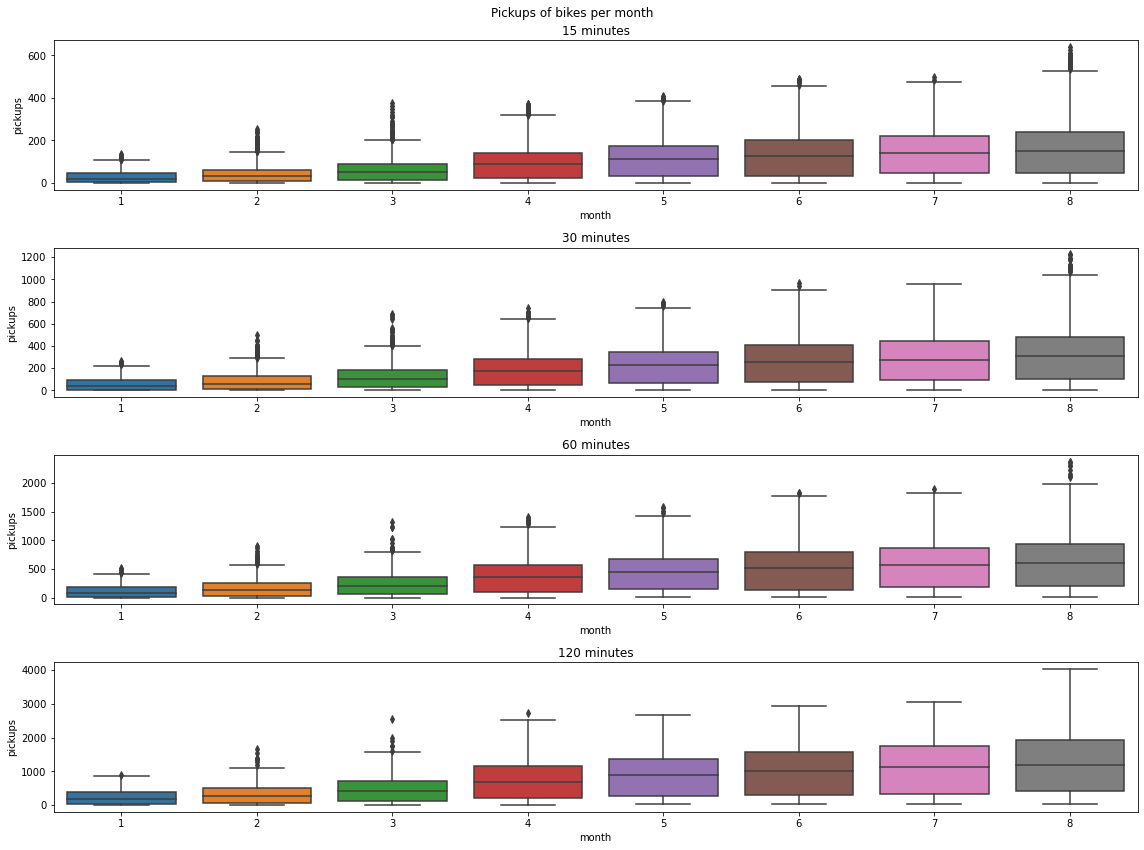

In [24]:
fig, axes = plt.subplots(len([picks15,picks30,picks60,picks120]), figsize=(16,12))
fig.suptitle('Pickups of bikes per month')

for i, df in enumerate([picks15,picks30,picks60,picks120]):
    sns.boxplot(ax=axes[i],x='month',y='pickups', data=df)

axes[0].set_title('15 minutes')
axes[1].set_title('30 minutes')
axes[2].set_title('60 minutes')
axes[3].set_title('120 minutes')

plt.tight_layout()

    As we can see the period of the day with the most demand is mainly at 11 am and also between 8 pm and 11 pm. 

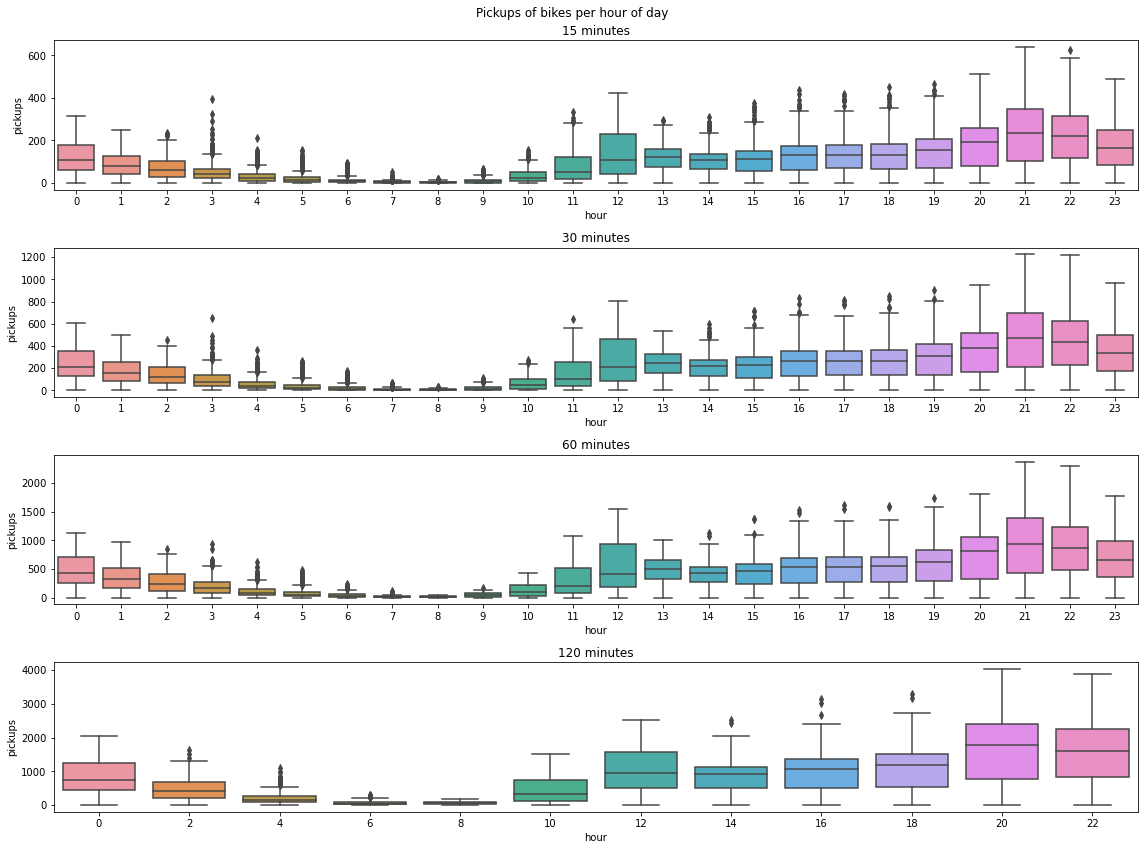

In [22]:
fig, axes = plt.subplots(len([picks15,picks30,picks60,picks120]), figsize=(16,12))
fig.suptitle('Pickups of bikes per hour of day')

for i, df in enumerate([picks15,picks30,picks60,picks120]):
    sns.boxplot(ax=axes[i], x='hour',y='pickups', data=df)

axes[0].set_title('15 minutes')
axes[1].set_title('30 minutes')
axes[2].set_title('60 minutes')
axes[3].set_title('120 minutes')

plt.tight_layout()

## Prediction challenge

    As we mentioned before, for the benchmark model we will predict the next two hours using only the lags of the time intervals. For this purpose we use 5 different models, three linears LinearRegression, Ridge, Lasso and two more robust ensembe models RandomForestRegressor, ExtraTreesRegressor. Our data has been standarized, by removing the mean and scaling to unit variance. Since we cannot suffle the data, we introduse the Backtesting approach in order to make a case if for the final prediction of our model. Backtesting assesses the viability of our model by discovering how it would play out using historical data and more specific we use it to predict as following:

![Backtesting](https://www.lokad.com/public/Upload/Support/Glossary/backtesting.svg)

In [37]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July']
training = []
i = 0
while i<=5:
    training.append(months[i])
    print('Train: ',training)
    print('Test: ',months[i+1])
    i+=1

Train:  ['January']
Test:  February
Train:  ['January', 'February']
Test:  March
Train:  ['January', 'February', 'March']
Test:  April
Train:  ['January', 'February', 'March', 'April']
Test:  May
Train:  ['January', 'February', 'March', 'April', 'May']
Test:  June
Train:  ['January', 'February', 'March', 'April', 'May', 'June']
Test:  July


In [145]:
# for the purpose of the prediction we have created a Class wchich we use ModelRunningResults funtion for calling it.
def ModelRunningResults(models,models_name, first_row, picks, weather_columns):
    results = {}
    table = [first_row]
    pipe = main.PredictionPipeline(picks,weather_columns)
    fi_dict = {}
    predictions = {}
    X_train, X_test, y_train, y_test = pipe.PredictionDataPreperation()
    for model, model_name in zip(models,models_name):
        CV_score, CV_MSE, test_score, test_MSE, fi, preds = pipe.BackTestingPrediction(model, model_name, X_train, X_test, y_train, y_test)
        results[model_name] = {'Test Score':test_score, 'Test MSE':test_MSE,  'Features Importance':fi}
        row = [model_name, test_score, test_MSE]
        table.append(row)      
        fi_dict[model_name] = fi
        predictions[model_name] = preds
    return table, fi_dict, predictions, y_test['pickups']

    Bellow we can check the backtesting performance of each model, using the r-squared score and the root mean squared error. Both in traing and testing phase.

In [173]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model for 15','Final Test Score','Final Test RMSE']
weather_columns = []
print('The Prediction based on {} minutes intervals \n'.format(15))
table15, features_importance15, predictions15, y_test_values = ModelRunningResults(models,models_name, first_row, picks15, weather_columns)

The Prediction based on 15 minutes intervals 


 LinearRegression

 Train Score:  0.7753762328425267
 Train RMSE :  12.67689057213289
 Test Score:     0.7542069063116529
 Test RMSE :     20.098985383511422

 Train Score:  0.7768742586630271
 Train RMSE :  16.38427627524303
 Test Score:     0.7106767156548907
 Test RMSE :     30.097351633437256

 Train Score:  0.7645684172004834
 Train RMSE :  21.89949932843529
 Test Score:     0.7471001883070908
 Test RMSE :     39.44839054120753

 Train Score:  0.7944529720596626
 Train RMSE :  27.09474790064098
 Test Score:     0.7481033924247611
 Test RMSE :     46.00667160719352

 Train Score:  0.8050286195701398
 Train RMSE :  31.78321439974883
 Test Score:     0.7137667070047515
 Test RMSE :     57.667476924251005

 Train Score:  0.7976502226211877
 Train RMSE :  37.23027735687573
 Test Score:     0.7319608186766087
 Test RMSE :     55.510414345427975

 RidgeRegression

 Train Score:  0.7752799024646057
 Train RMSE :  12.67960853643804
 Test Scor

    The results of our models in the final prediction using as training data the rides until July and test data the rides of August. 

In [174]:
print(tabulate(table15, headers='firstrow',colalign=("left",), floatfmt=".4f"))

Model for 15             Final Test Score    Final Test RMSE
---------------------  ------------------  -----------------
LinearRegression                   0.7475            64.2114
RidgeRegression                    0.7474            64.2137
LassoRegression                    0.7367            65.5662
RandomForestRegressor              0.8556            48.5598
ExtraTreesRegressor                0.8601            47.7923


   Extracting the importance of features we have used.

In [175]:
print('Featutes importance 15 min\n')
for model in models_name:
    print(model,'\n')
    for i,f in enumerate(features_importance15[model]):
        print(f,'\n')

Featutes importance 15 min

LinearRegression 

('month', 6.953502346250918) 

('hour', 2.8653445954080308) 

('minute', 0.021522258068993053) 

('lag(pickups,60-75)', 98.13706177292133) 

('lag(pickups,75-90)', 6.620692788302451) 

('lag(pickups,90-105)', -19.090638928378283) 

('lag(pickups,105-120)', -19.356114914817912) 

RidgeRegression 

('month', 6.9549989378813075) 

('hour', 2.8665642370077453) 

('minute', 0.021517578445498182) 

('lag(pickups,60-75)', 98.00821025674274) 

('lag(pickups,75-90)', 6.699101945182416) 

('lag(pickups,90-105)', -19.0346896584514) 

('lag(pickups,105-120)', -19.369014680966913) 

LassoRegression 

('month', 6.87919857412515) 

('hour', 3.225988959633901) 

('minute', 0.012837013100480094) 

('lag(pickups,60-75)', 76.59708522191049) 

('lag(pickups,75-90)', 0.0) 

('lag(pickups,90-105)', -0.0) 

('lag(pickups,105-120)', -11.121286169261367) 

RandomForestRegressor 

('month', 0.029709228364266076) 

('hour', 0.16615411297447322) 

('minute', 0.008669

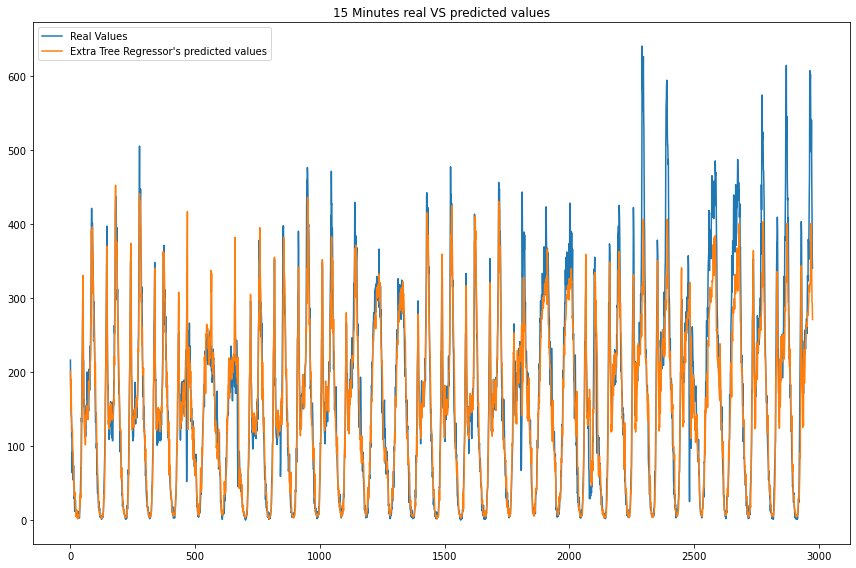

In [178]:
plt.figure(figsize=(12,8))
plt.title('15 Minutes real VS predicted values')
plt.plot(y_test_values.values, label='Real Values')
plt.plot(predictions15['ExtraTreesRegressor'], label="Extra Tree Regressor's predicted values")
plt.legend(loc="upper left")
plt.tight_layout()

    The same proccedure we have followed for all the different intervals.

In [179]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model for 30min','Final Test Score','Final Test RMSE']
weather_columns = []
print('The Prediction based on {} minutes intervals \n'.format(30))
table30, features_importance30, predictions30, y_test_values = ModelRunningResults(models,models_name, first_row, picks30,weather_columns)

The Prediction based on 30 minutes intervals 


 LinearRegression

 Train Score:  0.7649463311082461
 Train RMSE :  25.648178958494547
 Test Score:     0.7344728766700241
 Test RMSE :     41.39174759868678

 Train Score:  0.7627770385201709
 Train RMSE :  33.4669371801797
 Test Score:     0.6777229232225935
 Test RMSE :     63.06106439540864

 Train Score:  0.7431852394099271
 Train RMSE :  45.397745439203234
 Test Score:     0.7141600085576192
 Test RMSE :     83.31666481495797

 Train Score:  0.7727460157148357
 Train RMSE :  56.63009286317528
 Test Score:     0.7181230629441877
 Test RMSE :     96.68644952314791

 Train Score:  0.7840570214946705
 Train RMSE :  66.52502756767012
 Test Score:     0.675044510820424
 Test RMSE :     122.12297490522465

 Train Score:  0.7740875677296774
 Train RMSE :  78.26205238576209
 Test Score:     0.6946909008274949
 Test RMSE :     117.75771316166299

 RidgeRegression

 Train Score:  0.7642529932531236
 Train RMSE :  25.68597832417557
 Test Score:

In [180]:
print(tabulate(table30,headers='firstrow',colalign=("left",), floatfmt=".4f"))

Model for 30min          Final Test Score    Final Test RMSE
---------------------  ------------------  -----------------
LinearRegression                   0.7129           136.1535
RidgeRegression                    0.7128           136.1674
LassoRegression                    0.7064           137.6881
RandomForestRegressor              0.8518            97.8346
ExtraTreesRegressor                0.8550            96.7478


In [181]:
print('Featutes importance 30 min')
for model in models_name:
    print(model)
    for i,f in enumerate(features_importance30[model]):
        print(f,'\n')

Featutes importance 30 min
LinearRegression
('month', 15.823797215215112) 

('hour', 6.715483405144858) 

('minute', 0.06951039489991687) 

('lag(pickups,60-90)', 218.43056043331256) 

('lag(pickups,90-120)', -95.33337123121845) 

RidgeRegression
('month', 15.830728994383952) 

('hour', 6.724236352810168) 

('minute', 0.06935299924718505) 

('lag(pickups,60-90)', 217.83286576178526) 

('lag(pickups,90-120)', -94.77000561483109) 

LassoRegression
('month', 15.8076270469511) 

('hour', 7.217640702554631) 

('minute', 0.05493409468371062) 

('lag(pickups,60-90)', 180.5504833506886) 

('lag(pickups,90-120)', -58.564312003801525) 

RandomForestRegressor
('month', 0.05482891629872646) 

('hour', 0.22367234452405296) 

('minute', 0.007164045573817073) 

('lag(pickups,60-90)', 0.678438014083701) 

('lag(pickups,90-120)', 0.03589667951970249) 

ExtraTreesRegressor
('month', 0.08747372513486562) 

('hour', 0.28046465683278554) 

('minute', 0.010978823811789043) 

('lag(pickups,60-90)', 0.4000941

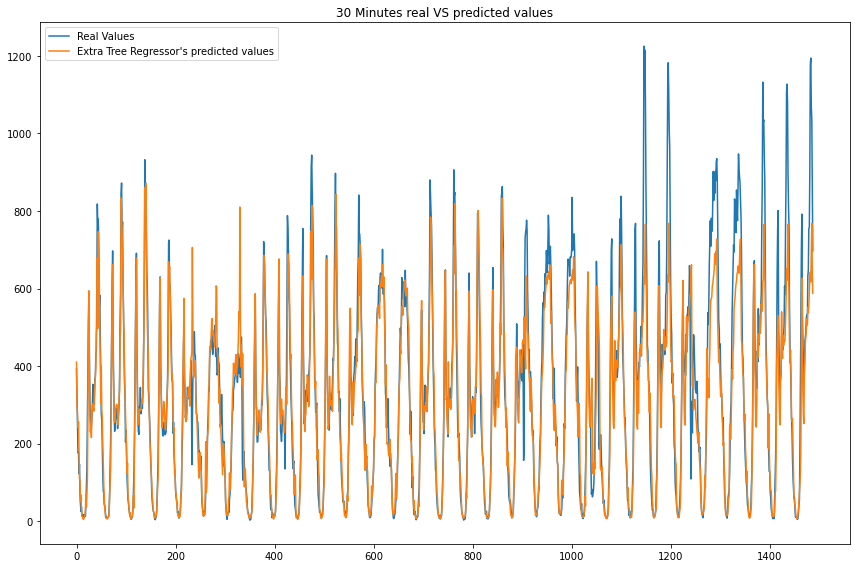

In [182]:
plt.figure(figsize=(12,8))
plt.title('30 Minutes real VS predicted values')
plt.plot(y_test_values.values, label='Real Values')
plt.plot(predictions30['ExtraTreesRegressor'], label="Extra Tree Regressor's predicted values")
plt.legend(loc="upper left")
plt.tight_layout()

In [183]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model for 60','Final Test Score','Final Test RMSE']
weather_columns = []
print('The Prediction based on {} minutes intervals \n'.format(60))
table60, features_importance60, predictions60, y_test_values  = ModelRunningResults(models,models_name, first_row, picks60,[])

The Prediction based on 60 minutes intervals 


 LinearRegression

 Train Score:  0.7325664716787956
 Train RMSE :  54.1255230794317
 Test Score:     0.6829401598304388
 Test RMSE :     89.45631639902517

 Train Score:  0.7236136682004484
 Train RMSE :  71.4848476570639
 Test Score:     0.5954420043949438
 Test RMSE :     139.8016502942177

 Train Score:  0.6877677020815383
 Train RMSE :  99.14063004198208
 Test Score:     0.6258954462300343
 Test RMSE :     188.70689753300843

 Train Score:  0.71629491968301
 Train RMSE :  125.473940240534
 Test Score:     0.6363373146006083
 Test RMSE :     217.47153702648848

 Train Score:  0.7288484331810179
 Train RMSE :  147.90972166630564
 Test Score:     0.5850254892359306
 Test RMSE :     273.0271220160186

 Train Score:  0.7162009514268604
 Train RMSE :  174.02697985874588
 Test Score:     0.5999554279860486
 Test RMSE :     266.92607156667697

 RidgeRegression

 Train Score:  0.7324106161583803
 Train RMSE :  54.141292480009795
 Test Score: 

In [184]:
print(tabulate(table60,headers='firstrow',colalign=("left",), floatfmt=".4f"))

Model for 60             Final Test Score    Final Test RMSE
---------------------  ------------------  -----------------
LinearRegression                   0.6157           311.7934
RidgeRegression                    0.6157           311.7944
LassoRegression                    0.6156           311.8182
RandomForestRegressor              0.8176           214.8114
ExtraTreesRegressor                0.8126           217.7275


In [185]:
for model in models_name:
    print(model)
    for f in features_importance60[model]:
        print(f,'\n')

LinearRegression
('month', 38.724462343702555) 

('hour', 20.08354364022422) 

('minute', 0.0) 

('lag(pickups,60-120)', 211.46416801151108) 

RidgeRegression
('month', 38.7372787692634) 

('hour', 20.08554598803659) 

('minute', 0.0) 

('lag(pickups,60-120)', 211.3969967051746) 

LassoRegression
('month', 38.754979418231244) 

('hour', 20.10221610637205) 

('minute', 0.0) 

('lag(pickups,60-120)', 210.19485668369236) 

RandomForestRegressor
('month', 0.08391065779774445) 

('hour', 0.2690448379497042) 

('minute', 0.0) 

('lag(pickups,60-120)', 0.6470445042525513) 

ExtraTreesRegressor
('month', 0.14717704181829128) 

('hour', 0.36696464786515387) 

('minute', 0.0) 

('lag(pickups,60-120)', 0.48585831031655485) 



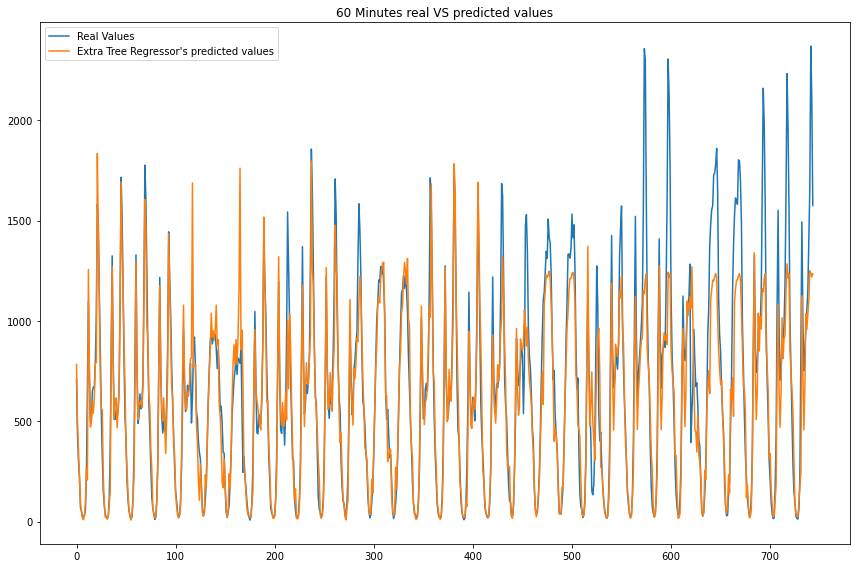

In [186]:
plt.figure(figsize=(12,8))
plt.title('60 Minutes real VS predicted values')
plt.plot(y_test_values.values, label='Real Values')
plt.plot(predictions60['ExtraTreesRegressor'], label="Extra Tree Regressor's predicted values")
plt.legend(loc="upper left")
plt.tight_layout()

In [187]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model for 120','Final Test Score','Final Test RMSE']
weather_columns = []
print('The Prediction based on {} minutes intervals \n'.format(120))
table120, features_importance120, predictions120, y_test_values = ModelRunningResults(models,models_name, first_row, picks120,[])

The Prediction based on 120 minutes intervals 


 LinearRegression

 Train Score:  0.7902167798097253
 Train RMSE :  93.4551380285334
 Test Score:     0.7515679713334942
 Test RMSE :     153.81233080349233

 Train Score:  0.7855821881304966
 Train RMSE :  122.58840107111025
 Test Score:     0.6736310482569444
 Test RMSE :     242.92643461775563

 Train Score:  0.7536216785813107
 Train RMSE :  171.29894499000304
 Test Score:     0.6913823856457634
 Test RMSE :     333.4444830062863

 Train Score:  0.7737585453556411
 Train RMSE :  218.86837686243038
 Test Score:     0.7106277538740229
 Test RMSE :     376.1156223920249

 Train Score:  0.7863580373359274
 Train RMSE :  256.585413759418
 Test Score:     0.6725781522261662
 Test RMSE :     466.0410325962561

 Train Score:  0.7787855235323475
 Train RMSE :  299.52226053269294
 Test Score:     0.6860706548454854
 Test RMSE :     454.6984802690551

 RidgeRegression

 Train Score:  0.7895600872871958
 Train RMSE :  93.60129685161439
 Test Sco

In [188]:
print(tabulate(table120,headers='firstrow',colalign=("left",), floatfmt=".4f"))

Model for 120            Final Test Score    Final Test RMSE
---------------------  ------------------  -----------------
LinearRegression                   0.6942           537.3486
RidgeRegression                    0.6942           537.3542
LassoRegression                    0.6942           537.3797
RandomForestRegressor              0.8556           369.2877
ExtraTreesRegressor                0.8556           369.3361


In [189]:
print('Featutes importance 120 min')
for model in models_name:
    print(model)
    for f in features_importance120[model]:
        print(f,'\n')

Featutes importance 120 min
LinearRegression
('month', 68.82276071727412) 

('hour', 39.15513937036979) 

('minute', 0.0) 

('lag(pickups,0-120)', 450.1916621025968) 

RidgeRegression
('month', 68.88223045710343) 

('hour', 39.16425392070967) 

('minute', 0.0) 

('lag(pickups,0-120)', 449.8972897251995) 

LassoRegression
('month', 68.86984818062282) 

('hour', 39.17629486231659) 

('minute', 0.0) 

('lag(pickups,0-120)', 448.89773975123325) 

RandomForestRegressor
('month', 0.05806396201105574) 

('hour', 0.23250892365384881) 

('minute', 0.0) 

('lag(pickups,0-120)', 0.7094271143350955) 

ExtraTreesRegressor
('month', 0.13572382285981938) 

('hour', 0.35323118679175536) 

('minute', 0.0) 

('lag(pickups,0-120)', 0.5110449903484252) 



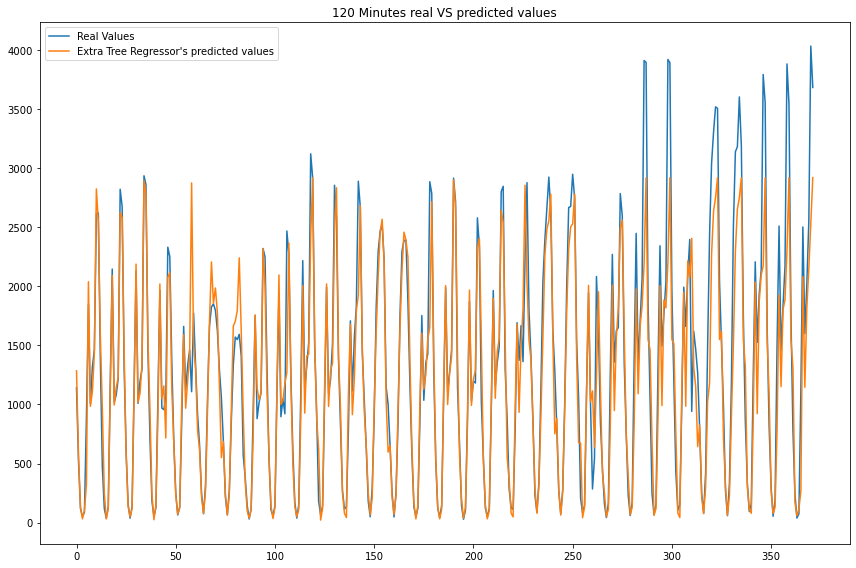

In [190]:
plt.figure(figsize=(12,8))
plt.title('120 Minutes real VS predicted values')
plt.plot(y_test_values.values, label='Real Values')
plt.plot(predictions120['ExtraTreesRegressor'], label="Extra Tree Regressor's predicted values")
plt.legend(loc="upper left")
plt.tight_layout()

    As a conclusion, we could infer that in every different interval the best algorithms are the non-linear ensemble models. Following the backtesting strategy, we could argue for the validity of our final prediction as we can see that constantly we achieve high score and low error. Although, the overall good performance of our models we are able to identify a small overfitting which we could probably avoid by changing our models parameters. Definitely the most important features are the lags of the intervals and obviously as smaller the interval is the better the prediction is something which is very logical!